In [19]:
import os
import numpy as np
import pandas as pd

In [20]:
import os
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 1. Loading data

In [21]:
train_data = pd.read_csv("lala/train_data-1599717478076.csv")
test_data = pd.read_csv("lala/test_data-1599717650029.csv")

In [22]:
train_data.head()

,transaction_number,user_id,payment_method,partner_id,partner_category,country,device_type,money_transacted,transaction_initiation,partner_pricing_category,is_fraud
0,144703125000,17539344,sbi_atm_cum_debit_card,47334,cat_1,IND_INR,android_devices,-5.0,2016-11-15 19:16:12+00:00,2,0
1,77406814453032,24710841,e_wallet_payments,78890,cat_2,IND_INR,other_pcs,100.0,2017-01-11 09:25:33+00:00,2,0
2,308929485482801,24265476,e_wallet_payments,78890,cat_2,IND_INR,other_pcs,50.0,2016-12-07 07:58:09+00:00,2,0
3,665270027747073,10240000,other_debit_cards,102557,cat_3,IND_INR,other_pcs,1000.0,2017-01-11 16:15:44+00:00,2,0
4,38276160171101,5880625,other_debit_cards,118335,cat_1,IND_INR,other_pcs,200.0,2016-11-16 17:04:42+00:00,2,0


## 2. EDA

In [23]:
train_data.size

841819

data has total of 841819 transactions

####  NULL Values

In [24]:
def fn_nulls_count(df):
    # Nulls counts in each column.
    nulls_counts = df.isnull().sum()
    # Convert above series into dataframe.
    nulls_counts_df = nulls_counts.to_frame(name = 'nulls_count')
    # Add a new column - to get the null counts percentage to the total rows.
    nulls_counts_df['nulls_percentage'] = round(100 * nulls_counts_df['nulls_count']/df.shape[0], 2)
    # Return the null counts dataframe.
    return nulls_counts_df

In [25]:
fn_nulls_count(train_data)

,nulls_count,nulls_percentage
transaction_number,0,0.0
user_id,0,0.0
payment_method,0,0.0
partner_id,0,0.0
partner_category,0,0.0
country,0,0.0
device_type,0,0.0
money_transacted,0,0.0
transaction_initiation,0,0.0
partner_pricing_category,0,0.0


In [26]:
fn_nulls_count(test_data)

,nulls_count,nulls_percentage
transaction_number,0,0.0
user_id,0,0.0
payment_method,0,0.0
partner_id,0,0.0
partner_category,0,0.0
country,0,0.0
device_type,0,0.0
money_transacted,0,0.0
transaction_initiation,0,0.0
partner_pricing_category,0,0.0


There are no null values

In [27]:
test_data.head()

,transaction_number,user_id,payment_method,partner_id,partner_category,country,device_type,money_transacted,transaction_initiation,partner_pricing_category
0,857050141038272,3802500,visa_master_debit_cards,118335,cat_1,IND_INR,other_pcs,200.0,2016-12-28 14:44:37+00:00,2
1,4400462872603,200704,e_wallet_payments,23667,cat_2,IND_INR,other_pcs,20.0,2016-12-14 17:49:48+00:00,2
2,1207915598569499,25150225,sbi_atm_cum_debit_card,47334,cat_1,IND_INR,android_devices,-100.0,2017-01-21 10:18:11+00:00,2
3,2009725616777536,21827584,visa_master_credit_cards,78890,cat_2,IND_INR,other_pcs,200.0,2017-01-16 13:25:10+00:00,1
4,2319205210274863,576081,e_wallet_payments,23667,cat_2,IND_INR,other_pcs,100.0,2017-02-09 12:47:28+00:00,2


In [28]:
train_data.nunique()

transaction_number          76529
user_id                      3594
payment_method                  6
partner_id                     23
partner_category                9
country                         1
device_type                     4
money_transacted             1454
transaction_initiation      75811
partner_pricing_category        4
is_fraud                        2
dtype: int64

#### Dropping Country and transaction_number
All transactions are from India. There is no need of country column. Transaction_number is a unique transaction number is also a unique id number.

In [29]:
train_data = train_data.drop(["transaction_number","country"],axis=1)
test_data = test_data.drop(["transaction_number","country"],axis=1)

#### Typecasting

Sperating target variable first

In [30]:
Y = train_data["is_fraud"]
train_data = train_data.drop(["is_fraud"],axis=1)

In [31]:
train_data.dtypes

user_id                       int64
payment_method               object
partner_id                    int64
partner_category             object
device_type                  object
money_transacted            float64
transaction_initiation       object
partner_pricing_category      int64
dtype: object

```transaction_initiation``` is a date category

In [32]:
train_data.transaction_initiation = pd.to_datetime(train_data.transaction_initiation)
test_data.transaction_initiation = pd.to_datetime(test_data.transaction_initiation)

```['user_id', 'payment_method', 'partner_id', 'partner_category','device_type','partner_pricing_category']``` are categorical

In [33]:
for each in ['user_id', 'payment_method', 'partner_id', 'partner_category','device_type','partner_pricing_category']:
    train_data[each] = train_data[each].astype('category')
    test_data[each] = test_data[each].astype('category')

In [34]:
test_data.dtypes

user_id                                category
payment_method                         category
partner_id                             category
partner_category                       category
device_type                            category
money_transacted                        float64
transaction_initiation      datetime64[ns, UTC]
partner_pricing_category               category
dtype: object

#### Creating relevant time features

In [35]:
train_data["year"] = pd.DataFrame(train_data.transaction_initiation.dt.year).astype('category')
train_data["month"] = pd.DataFrame(train_data.transaction_initiation.dt.month).astype('category')
train_data["hour"] = pd.DataFrame(train_data.transaction_initiation.dt.hour).astype('category')
train_data["weekofyear"] = pd.DataFrame(train_data.transaction_initiation.dt.weekofyear).astype('category')


In [36]:
test_data["year"] = pd.DataFrame(test_data.transaction_initiation.dt.year).astype('category')
test_data["month"] = pd.DataFrame(test_data.transaction_initiation.dt.month).astype('category')
test_data["hour"] = pd.DataFrame(test_data.transaction_initiation.dt.hour).astype('category')
test_data["weekofyear"] = pd.DataFrame(test_data.transaction_initiation.dt.weekofyear).astype('category')

In [37]:
train_data["year"] = train_data["year"].astype('category')
train_data["month"] = train_data["month"].astype('category')
train_data["hour"] = train_data["hour"].astype('category')
train_data["weekofyear"] = train_data["weekofyear"].astype('category')


test_data["year"] = test_data["year"].astype('category')
test_data["month"] = test_data["month"].astype('category')
test_data["hour"] = test_data["hour"].astype('category')
test_data["weekofyear"] = test_data["weekofyear"].astype('category')


In [38]:
train_data.head()

,user_id,payment_method,partner_id,partner_category,device_type,money_transacted,transaction_initiation,partner_pricing_category,year,month,hour,weekofyear
0,17539344,sbi_atm_cum_debit_card,47334,cat_1,android_devices,-5.0,2016-11-15 19:16:12+00:00,2,2016,11,19,46
1,24710841,e_wallet_payments,78890,cat_2,other_pcs,100.0,2017-01-11 09:25:33+00:00,2,2017,1,9,2
2,24265476,e_wallet_payments,78890,cat_2,other_pcs,50.0,2016-12-07 07:58:09+00:00,2,2016,12,7,49
3,10240000,other_debit_cards,102557,cat_3,other_pcs,1000.0,2017-01-11 16:15:44+00:00,2,2017,1,16,2
4,5880625,other_debit_cards,118335,cat_1,other_pcs,200.0,2016-11-16 17:04:42+00:00,2,2016,11,17,46


setting aside the time column since relevant data has been extracted from it

In [39]:
train_time = train_data["transaction_initiation"]
train_data = train_data.drop(["transaction_initiation"],axis=1)
test_time = test_data["transaction_initiation"]
test_data = test_data.drop(["transaction_initiation"],axis=1)

In [40]:
train_data.dtypes

user_id                     category
payment_method              category
partner_id                  category
partner_category            category
device_type                 category
money_transacted             float64
partner_pricing_category    category
year                        category
month                       category
hour                        category
weekofyear                  category
dtype: object

## Insights and Visualizations

In [41]:
train_data.describe()

,money_transacted
count,76529.000000
mean,132.724348
std,2350.110900
min,-20000.000000
25%,-1.000000
50%,20.000000
75%,52.000000
max,197217.760000


In [42]:
train_data["payment_method"].value_counts()

sbi_atm_cum_debit_card        30538
e_wallet_payments             27384
visa_master_debit_cards       11643
other_debit_cards              4495
visa_master_credit_cards       2454
unified_payments_interface       15
Name: payment_method, dtype: int64

In [43]:
train_y = pd.DataFrame(Y)

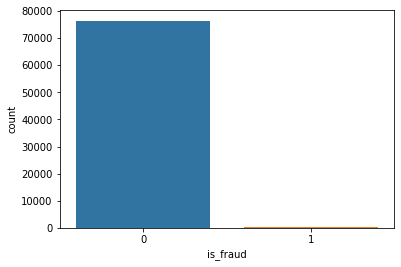

0    76375
1      154
Name: is_fraud, dtype: int64


In [44]:
sns.countplot(x=train_y.is_fraud)
plt.show()

# What are the counts?
print(pd.DataFrame(Y).is_fraud.value_counts())

Data is Imbalanced

In [45]:
train_data.partner_pricing_category

0        2
1        2
2        2
3        2
4        2
        ..
76524    2
76525    2
76526    2
76527    2
76528    2
Name: partner_pricing_category, Length: 76529, dtype: category
Categories (4, int64): [0, 1, 2, 4]

In [46]:
all_data = pd.concat([train_data,train_y],axis=1)

In [47]:
all_data.nunique()

user_id                     3594
payment_method                 6
partner_id                    23
partner_category               9
device_type                    4
money_transacted            1454
partner_pricing_category       4
year                           2
month                          4
hour                          24
weekofyear                    14
is_fraud                       2
dtype: int64

All frauds are being committed by these 48 customers. 

Out of 23 partners, 9 faced fraud issues

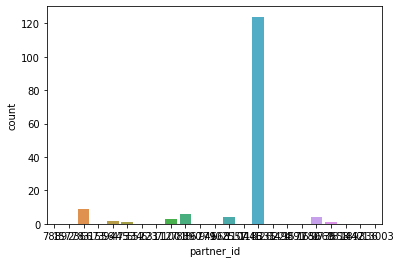

In [283]:
sns.countplot(x=all_data[all_data.is_fraud==1].partner_id)

In [109]:
fraudstes_users = set(all_data[all_data.is_fraud==1]["user_id"].values)

In [111]:
train_data_customized = all_data[all_data["user_id"].apply(lambda x : x in fraudstesL).values]
len(train_data_customized)

2691

these 48 fraud user ids have 2691 transactions and they account for all the 154 frauds

One particular partner is facing most of the frauds

In [112]:
all_data[all_data.is_fraud==1].groupby(by = ["partner_id"]).count()

,user_id,payment_method,partner_category,device_type,money_transacted,partner_pricing_category,year,month,hour,weekofyear,is_fraud
partner_id,,,,,,,,,,,
7889,0,0,0,0,0,0,0,0,0,0,0
15778,0,0,0,0,0,0,0,0,0,0,0
23667,9,9,9,9,9,9,9,9,9,9,9
31556,0,0,0,0,0,0,0,0,0,0,0
39445,2,2,2,2,2,2,2,2,2,2,2
47334,1,1,1,1,1,1,1,1,1,1,1
55223,0,0,0,0,0,0,0,0,0,0,0
63112,0,0,0,0,0,0,0,0,0,0,0
71001,3,3,3,3,3,3,3,3,3,3,3


Partner_id with 118335 constitutes to 124 out of 154 frauds!

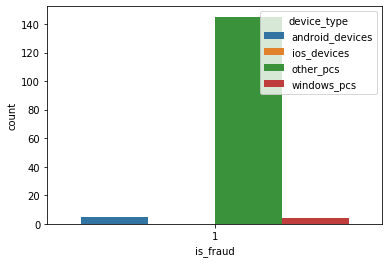

In [113]:
sns.countplot(x = all_data[all_data.is_fraud==1].is_fraud,hue = all_data["device_type"],data = all_data[all_data.is_fraud==1])

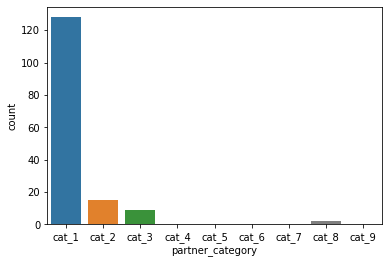

In [114]:
sns.countplot(x=all_data[all_data.is_fraud==1].partner_category)

In [115]:
train_data.groupby(by = ["is_fraud","user_id"]).count()

payment_method  partner_id  partner_category  device_type  \
is_fraud user_id                                                               
0        1                    NaN         NaN               NaN          NaN   
         4                    NaN         NaN               NaN          NaN   
         9                    NaN         NaN               NaN          NaN   
         16                   NaN         NaN               NaN          NaN   
         25                   NaN         NaN               NaN          NaN   
...                           ...         ...               ...          ...   
1        55860676             NaN         NaN               NaN          NaN   
         55875625             NaN         NaN               NaN          NaN   
         55890576             NaN         NaN               NaN          NaN   
         55905529             NaN         NaN               NaN          NaN   
         55920484             NaN         NaN               NaN          NaN   

                   money_transacted  partner_pricing_category  year  month  \
is_fraud user_id                                                             
0        1                      NaN                       NaN   NaN    NaN   
         4                      NaN                       NaN   NaN    NaN   
         9                      NaN                       NaN   NaN    NaN   
         16                     NaN                       NaN   NaN    NaN   
         25                     NaN                       NaN   NaN    NaN   
...                             ...                       ...   ...    ...   
1        55860676               NaN                       NaN   NaN    NaN   
         55875625               NaN                       NaN   NaN    NaN   
         55890576               NaN                       NaN   NaN    NaN   
         55905529               NaN                       NaN   NaN    NaN   
         55920484               NaN                       NaN   NaN    NaN   

                   hour  weekofyear  
is_fraud user_id                     
0        1          NaN         NaN  
         4          NaN         NaN  
         9          NaN         NaN  
         16         NaN         NaN  
         25         NaN         NaN  
...                 ...         ...  
1        55860676   NaN         NaN  
         55875625   NaN         NaN  
         55890576   NaN         NaN  
         55905529   NaN         NaN  
         55920484   NaN         NaN  

[7188 rows x 10 columns]

In [116]:
all_data.groupby(by = ["is_fraud","partner_category"]).count()['user_id']

is_fraud  partner_category
0         cat_1               36178.0
          cat_2               36004.0
          cat_3                1527.0
          cat_4                1310.0
          cat_5                1026.0
          cat_6                 146.0
          cat_7                 165.0
          cat_8                  17.0
          cat_9                   2.0
1         cat_1                 128.0
          cat_2                  15.0
          cat_3                   9.0
          cat_4                   NaN
          cat_5                   NaN
          cat_6                   NaN
          cat_7                   NaN
          cat_8                   2.0
          cat_9                   NaN
Name: user_id, dtype: float64

A few Categories are in contrast.
* 1 has 128 frauds while 2 has only 15 with while transactions occur with similar frequency in both categories.
* Cat_8 has 2 frauds od it's 20 transactions. 
* of 1527 transacctions, cat_3 has only 9 frauds

cat_8 is to be flagged

In [117]:
all_data.groupby(by = ["is_fraud","device_type"]).count()

user_id  payment_method  partner_id  \
is_fraud device_type                                            
0        android_devices  29657.0         29657.0     29657.0   
         ios_devices        876.0           876.0       876.0   
         other_pcs        45415.0         45415.0     45415.0   
         windows_pcs        427.0           427.0       427.0   
1        android_devices      5.0             5.0         5.0   
         ios_devices          NaN             NaN         NaN   
         other_pcs          145.0           145.0       145.0   
         windows_pcs          4.0             4.0         4.0   

                          partner_category  money_transacted  \
is_fraud device_type                                           
0        android_devices           29657.0           29657.0   
         ios_devices                 876.0             876.0   
         other_pcs                 45415.0           45415.0   
         windows_pcs                 427.0             427.0   
1        android_devices               5.0               5.0   
         ios_devices                   NaN               NaN   
         other_pcs                   145.0             145.0   
         windows_pcs                   4.0               4.0   

                          partner_pricing_category     year    month     hour  \
is_fraud device_type                                                            
0        android_devices                   29657.0  29657.0  29657.0  29657.0   
         ios_devices                         876.0    876.0    876.0    876.0   
         other_pcs                         45415.0  45415.0  45415.0  45415.0   
         windows_pcs                         427.0    427.0    427.0    427.0   
1        android_devices                       5.0      5.0      5.0      5.0   
         ios_devices                           NaN      NaN      NaN      NaN   
         other_pcs                           145.0    145.0    145.0    145.0   
         windows_pcs                           4.0      4.0      4.0      4.0   

                          weekofyear  
is_fraud device_type                  
0        android_devices     29657.0  
         ios_devices           876.0  
         other_pcs           45415.0  
         windows_pcs           427.0  
1        android_devices         5.0  
         ios_devices             NaN  
         other_pcs             145.0  
         windows_pcs             4.0

it can be inferred
* No fraud took place with ios_devices
* most fraud occured with other_pcs
* Hardly any fraud happened with android_devices 5 frauds out of 29576 transactions

Most fraud is taking place through other_pcs. Transactions through other pc's need stronger scrutinizing.

In [118]:
all_data.groupby(by = ["is_fraud","hour"]).count()

user_id  payment_method  partner_id  partner_category  \
is_fraud hour                                                          
0        0       132.0           132.0       132.0             132.0   
         1       141.0           141.0       141.0             141.0   
         2       231.0           231.0       231.0             231.0   
         3       569.0           569.0       569.0             569.0   
         4      1841.0          1841.0      1841.0            1841.0   
         5      3364.0          3364.0      3364.0            3364.0   
         6      4284.0          4284.0      4284.0            4284.0   
         7      4534.0          4534.0      4534.0            4534.0   
         8      4505.0          4505.0      4505.0            4505.0   
         9      4339.0          4339.0      4339.0            4339.0   
         10     4793.0          4793.0      4793.0            4793.0   
         11     4964.0          4964.0      4964.0            4964.0   
         12     4117.0          4117.0      4117.0            4117.0   
         13     4142.0          4142.0      4142.0            4142.0   
         14     4133.0          4133.0      4133.0            4133.0   
         15     5056.0          5056.0      5056.0            5056.0   
         16     5801.0          5801.0      5801.0            5801.0   
         17     5889.0          5889.0      5889.0            5889.0   
         18     5084.0          5084.0      5084.0            5084.0   
         19     4066.0          4066.0      4066.0            4066.0   
         20     2455.0          2455.0      2455.0            2455.0   
         21     1171.0          1171.0      1171.0            1171.0   
         22      544.0           544.0       544.0             544.0   
         23      220.0           220.0       220.0             220.0   
1        0         1.0             1.0         1.0               1.0   
         1         NaN             NaN         NaN               NaN   
         2         NaN             NaN         NaN               NaN   
         3         6.0             6.0         6.0               6.0   
         4         NaN             NaN         NaN               NaN   
         5         5.0             5.0         5.0               5.0   
         6         6.0             6.0         6.0               6.0   
         7         9.0             9.0         9.0               9.0   
         8         4.0             4.0         4.0               4.0   
         9         6.0             6.0         6.0               6.0   
         10        2.0             2.0         2.0               2.0   
         11        6.0             6.0         6.0               6.0   
         12       23.0            23.0        23.0              23.0   
         13       16.0            16.0        16.0              16.0   
         14        7.0             7.0         7.0               7.0   
         15        7.0             7.0         7.0               7.0   
         16       13.0            13.0        13.0              13.0   
         17       10.0            10.0        10.0              10.0   
         18        9.0             9.0         9.0               9.0   
         19        4.0             4.0         4.0               4.0   
         20        8.0             8.0         8.0               8.0   
         21        9.0             9.0         9.0               9.0   
         22        3.0             3.0         3.0               3.0   
         23        NaN             NaN         NaN               NaN   

               device_type  money_transacted  partner_pricing_category  \
is_fraud hour                                                            
0        0           132.0             132.0                     132.0   
         1           141.0             141.0                     141.0   
         2           231.0             231.0                     231.0   
         3           569.0             569.0

hour 12,13,16 and 17 have higher frequency of frauds. Most fraud occured at daytime.

In [119]:
all_data.money_transacted.describe()

count     76529.000000
mean        132.724348
std        2350.110900
min      -20000.000000
25%          -1.000000
50%          20.000000
75%          52.000000
max      197217.760000
Name: money_transacted, dtype: float64

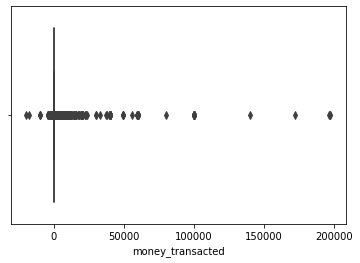

In [120]:
sns.boxplot(all_data.money_transacted)

In [121]:
!pip install imblearn

  Using cached scikit_learn-0.23.2-cp37-cp37m-win_amd64.whl (6.8 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.21.2
    Uninstalling scikit-learn-0.21.2:
      Successfully uninstalled scikit-learn-0.21.2


ERROR: deeppavlov 0.13.0 has requirement requests==2.22.0, but you'll have requests 2.25.0 which is incompatible.
ERROR: deeppavlov 0.13.0 has requirement ruamel.yaml==0.15.100, but you'll have ruamel-yaml 0.15.87 which is incompatible.
ERROR: deeppavlov 0.13.0 has requirement scikit-learn==0.21.2, but you'll have scikit-learn 0.23.2 which is incompatible.
ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\users\\multi\\anaconda3\\lib\\site-packages\\~-learn\\datasets\\_svmlight_format.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [122]:
train_data.dtypes

user_id                     category
payment_method              category
partner_id                  category
partner_category            category
device_type                 category
money_transacted             float64
partner_pricing_category    category
year                        category
month                       category
hour                        category
weekofyear                  category
is_fraud                       int64
dtype: object

In [123]:
train_data = train_data_customized

## Modelling

In [124]:
categorical_columns = ['user_id', 'payment_method', 'partner_id', 'partner_category',
       'device_type', 'partner_pricing_category', 'year',
       'month', 'hour', 'weekofyear']
X_train = train_data
X_test = test_data
num_X_train = pd.DataFrame(train_data["money_transacted"])
num_X_test = pd.DataFrame(test_data["money_transacted"])

In [125]:

num_X_test

,money_transacted
0,200.0
1,20.0
2,-100.0
3,200.0
4,100.0
...,...
19128,20.0
19129,30.0
19130,20.0
19131,-500.0


#### Dummifying

In [126]:
Xtrain.shape

(2691, 130)

In [127]:
# YOUR CODE HERE
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[categorical_columns]))
OH_cols_test  = pd.DataFrame(OH_encoder.transform(X_test[categorical_columns]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_test.index = X_test.index

# One-hot encoding assigns the sequence numbers as the columns names.
OH_cols_train.columns = OH_encoder.get_feature_names()
OH_cols_test.columns  = OH_encoder.get_feature_names()

# Add one-hot encoded columns to imputed numerical features
Xtrain = pd.concat([num_X_train, OH_cols_train], axis=1)
Final_X_test  = pd.concat([num_X_test, OH_cols_test], axis=1)

#### Splitting into train and Valid

In [128]:
Final_X_train, Final_X_valid, y_train, y_valid = train_test_split(Xtrain, 
                                                    Y, 
                                                    train_size=0.8, 
                                                    test_size=0.2,
                                                    random_state=0)

ValueError: Found input variables with inconsistent numbers of samples: [2691, 76529]

In [ ]:
X_test.shape

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_jobs = -1,
                             random_state = 1)

In [ ]:
# Function for training the model
from sklearn.metrics import make_scorer

def fn_train_model(model, 
                X_train, 
                y_train, 
                parameters = None, 
                k = 1):
    if parameters == None:
        model.fit(X_train, y_train) 
    else:
        model_cv = GridSearchCV(model, 
                                param_grid = parameters, 
                                cv = k,
                                scoring = make_scorer(
                                    lambda yt,yp: f1_score(yt,yp,pos_label = 1)))
        model_cv.fit(X_train, y_train)
        model = model_cv.best_estimator_
        
    return model

In [ ]:
base_model = fn_train_model(rfc, 
                            Final_X_train,
                            y_train)

In [ ]:
base_model

In [ ]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score

def fn_compute_metrics(model,
                       model_name,
                       train_data, 
                       train_actuals,
                       test_data,
                       test_actuals):
    metrics = {}
    # train metrics
    train_predictions = model.predict(train_data)
    metrics['train_accuracy']    = accuracy_score(train_actuals, train_predictions)
    metrics['train_precision']   = precision_score(train_actuals, train_predictions)
    metrics['train_recall']      = recall_score(train_actuals, train_predictions)
    metrics['train_f1_score']    = f1_score(train_actuals, train_predictions)
    # test metrics
    test_predictions  = model.predict(test_data)
    metrics['test_accuracy']     = accuracy_score(test_actuals, test_predictions)
    metrics['test_precision']    = precision_score(test_actuals, test_predictions)
    metrics['test_recall']       = recall_score(test_actuals, test_predictions)
    metrics['test_f1_score']     = f1_score(test_actuals, test_predictions)
    
    return pd.Series(metrics, name = model_name)

In [ ]:
base_model_metrics = fn_compute_metrics(base_model,
                                        'base_model',
                                        Final_X_train,
                                        y_train,
                                        Final_X_valid,y_valid)

In [ ]:
base_model_metrics

In [ ]:
base_model_submission = base_model.predict(Final_X_test)
pd.DataFrame(base_model_submission).to_csv("base_model_submission.csv")

#### Model2

In [ ]:
rfc1 = RandomForestClassifier(n_jobs = -1,
                             random_state = 1,class_weight = 'balanced')

In [ ]:
#parameters = {"class_weight" : ['balanced']}

cv_model_1 = fn_train_model(rfc1,
                          Final_X_train,
                          y_train,)


cv_model_1_metrics = fn_compute_metrics(cv_model_1,
                                      'parameters_1',
                                       Final_X_train,
                                       y_train,
                                       Final_X_valid,
                                       y_valid)

print(cv_model_1)

In [ ]:
print(cv_model_1_metrics)

#### Model3

In [ ]:
rfc2 = RandomForestClassifier(n_jobs = -1,
                             random_state = 1,class_weight = 'balanced_subsample',n_estimators = 150)
cv_model_2 = fn_train_model(rfc2,
                          Final_X_train,
                          y_train,)


cv_model_2_metrics = fn_compute_metrics(cv_model_2,
                                      'parameters_2',
                                       Final_X_train,
                                       y_train,
                                       Final_X_valid,
                                       y_valid)

print(cv_model_2_metrics)

In [ ]:
for each in list(cv_model_2.feature_importances_):
    if each>0.05:
        print(each)

#### Model4

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators = 15, random_state = 2)

In [ ]:
cv_model_3 = fn_train_model(xgb_model,
                          Final_X_train,
                          y_train,)


cv_model_3_metrics = fn_compute_metrics(cv_model_3,
                                      'parameters_3',
                                       Final_X_train,
                                       y_train,
                                       Final_X_valid,
                                       y_valid)

print(cv_model_3_metrics)

In [ ]:
cv_model_3_submission = cv_model_3.predict(Final_X_test)
pd.DataFrame(cv_model_3_submission).to_csv("cv_model_3_submission.csv")

#### Model5:DT

In [ ]:
from sklearn.tree import DecisionTreeClassifier
#{class_label: weight}
dtc = DecisionTreeClassifier(class_weight = {0:0.5,1:0.5} )

In [ ]:
cv_model_4 = fn_train_model(dtc,
                          Final_X_train,
                          y_train,k=5)

cv_model_4_metrics = fn_compute_metrics(cv_model_4,
                                      'parameters_4',
                                       Final_X_train,
                                       y_train,
                                       Final_X_valid,
                                       y_valid)

print(cv_model_4_metrics)

In [ ]:
#cv_model_4_submission = cv_model_4.predict(Final_X_test)
#pd.DataFrame(cv_model_4_submission).to_csv("cv_model_4_submission.csv")

In [ ]:
xgb1 = XGBClassifier(
    learning_rate =0.99, n_estimators=10,
    objective= 'binary:logistic',scale_pos_weight=20)

In [ ]:
#parameters = {'max_depth' : range(1,5), 
 #             'class_weight' : ['balanced']
  #           }

cv_model_5 = fn_train_model(xgb1,
                          Final_X_train,
                          y_train,k=5)

cv_model_5_metrics = fn_compute_metrics(cv_model_5,
                                      'parameters_5',
                                       Final_X_train,
                                       y_train,
                                       Final_X_valid,
                                       y_valid)

print(cv_model_5_metrics)

In [ ]:
from lightgbm import LGBMClassifier


lgbm_model = LGBMClassifier(n_estimators = 500,
                            learning_rate = 0.025,
                            n_jobs = 4,
                            random_state = 2)


In [ ]:
cv_model_6 = fn_train_model(lgbm_model,
                          Final_X_train,
                          y_train,k=5)

cv_model_6_metrics = fn_compute_metrics(cv_model_6,
                                      'parameters_6',
                                       Final_X_train,
                                       y_train,
                                       Final_X_valid,
                                       y_valid)

print(cv_model_6_metrics)

In [ ]:
#cv_model_dum_submission = cv_model_6.predict(Final_X_test)
#pd.DataFrame(cv_model_dum_submission).to_csv("cv_model_dum_submission.csv")

Since cv_model_4 is providing the best f1 scores, it is being chosen for modelling

In [ ]:
cv_model_4_submission = cv_model_4.predict(Final_X_test)
pd.DataFrame(cv_model_4_submission).to_csv("cv_model_last_submission.csv")